In [13]:
# Successfully using this file requires the existence of "data.csv".
# This can be generated with the "load_Allen_Visual_Behavior_from_pre_processed_file.ipynb" notebook.

# Running this file will output files to neural data per mouse under data/neural_activity
# Runtime about 2 minutes

import pandas as pd
import ast
import os

from helper_functions import create_neural_traces_per_label

In [14]:
data_csv_path =        "data.csv"
columns_of_interest = ["stimulus_presentations_id", "cell_specimen_id", "trace",
                       "trace_timestamps", "image_name", "image_index", "mouse_id",
                       "animal_in_image", "close_proximity"]

create_neural_traces_per_label(data_csv_path, columns_of_interest)

data = pd.read_csv("data/neural_activity_per_trial.csv")
print(data.shape)

Excluded 88 because of duplicate cell_specimen_ids.
The combinations of ['stimulus_presentations_id', 'mouse_id'] is unique. To do so, 465 out of 9209 trials have been ignored.
(8744, 9)


In [15]:
# Print how many mice there are, and how many trialy per mouse there are in the dataset.
i_mice = data["mouse_id"].unique()
print(f"Number of mice: {len(i_mice)}\n")

trials_per_mouse =               data.groupby("mouse_id").size()

trials_per_mouse_data =          trials_per_mouse.reset_index(name='n_trials')
trials_per_mouse_data.columns = ['mouse_id', 'n_trials']
trials_per_mouse_data =          trials_per_mouse_data.sort_values(by='n_trials', ascending=False)

print(f"Trials per mouse, ordered by trial count:\n\n{trials_per_mouse_data.to_string(index=False)}")

Number of mice: 13

Trials per mouse, ordered by trial count:

 mouse_id  n_trials
   476970      1160
   492395      1151
   467953       830
   486737       745
   467954       710
   477202       710
   489066       679
   485688       604
   480753       505
   470784       498
   467951       448
   489056       378
   498972       326


The 13 mice have between 326 and 1160 per mouse, which is enough to meaningfully use classifiers.

The next question however is, if all trials contain the same or different neurons. If they contain different neurons per trial, analysis will be more difficult.

In [16]:
# Print how often each neuron appears in the trials per mouse.

neuron_counts = {}
always_occuring_neurons_count = {}

for mouse_id in i_mice:
    neuron_counts[mouse_id] =                 {}
    mouse_trials =                            data[data["mouse_id"] == mouse_id]
    always_occuring_neurons_count[mouse_id] = 0

    n_trials = len(mouse_trials)
    
    for neuron_list in mouse_trials["cell_specimen_id"]:
        for neuron_id in [int(neuron_id) for neuron_id in neuron_list.strip("[]").split(", ")]:
            if neuron_id not in neuron_counts[mouse_id]: neuron_counts[mouse_id][neuron_id] = 0  
            neuron_counts[mouse_id][neuron_id] += 1

    for neuron_id in list(neuron_counts[mouse_id].keys()):
        if neuron_counts[mouse_id][neuron_id] == n_trials: always_occuring_neurons_count[mouse_id] += 1
        neuron_counts[mouse_id][neuron_id] = round(neuron_counts[mouse_id][neuron_id] / n_trials * 100, 3)

for mouse_id in list(neuron_counts.keys()):
    print(f"\nMouse {mouse_id} - {always_occuring_neurons_count[mouse_id]} Neurons appear in all {len(data[data['mouse_id'] == mouse_id])} trials\n  Neurons:")
    for neuron_id, neuron_percentage in sorted(neuron_counts[mouse_id].items(), key=lambda item: item[1], reverse=True):
        print(f"    {neuron_id}: {neuron_percentage} %")


Mouse 492395 - 15 Neurons appear in all 1151 trials
  Neurons:
    1086557082: 100.0 %
    1086560048: 100.0 %
    1086559782: 100.0 %
    1086558904: 100.0 %
    1086559446: 100.0 %
    1086555190: 100.0 %
    1086555432: 100.0 %
    1086567017: 100.0 %
    1086560592: 100.0 %
    1086567589: 100.0 %
    1086558341: 100.0 %
    1086556696: 100.0 %
    1086563032: 100.0 %
    1086563829: 100.0 %
    1086561466: 100.0 %
    1086561830: 76.803 %
    1086557997: 76.803 %
    1086556416: 76.803 %
    1086560926: 76.803 %
    1086562430: 76.803 %
    1086566746: 63.076 %
    1086566230: 63.076 %
    1086563384: 63.076 %
    1086565528: 63.076 %
    1086562780: 63.076 %
    1086559188: 60.122 %
    1086567897: 60.122 %
    1086556094: 60.122 %
    1086569757: 39.878 %
    1086565788: 39.878 %
    1086568632: 39.878 %
    1086573070: 39.878 %
    1086568315: 39.878 %
    1086568830: 39.878 %
    1086566623: 39.878 %
    1086565124: 39.878 %
    1086569063: 39.878 %
    1086563601: 39.878 %
 

Per mouse, between 3 and 18 Neurons appear on every trial.

Examples with over 10 Neurons will likely be more interesting than ones with e.g. 3.

Neurons that do not appear on every trial are harder to use.

Mouse 492395 looks especially promising, as it has the highest number of trials and 15 neurons recorded across all of them.

For the intended hypothesis, the next question is, how many different images are contained in the trials. If there are only a few of them, overfitting must be avoided.

In [17]:
# Print image occurrences per mouse trials

image_counts = {}

for mouse_id in i_mice:
    image_counts[mouse_id] = {}
    mouse_trials =           data[data["mouse_id"] == mouse_id]

    n_trials = len(mouse_trials)

    for image_name in mouse_trials["image_name"]:
            if image_name not in image_counts[mouse_id]: image_counts[mouse_id][image_name] = 0  
            image_counts[mouse_id][image_name] += 1

    for image_name in list(image_counts[mouse_id].keys()):
        image_counts[mouse_id][image_name] = round(image_counts[mouse_id][image_name] / n_trials * 100, 3)

for mouse_id in list(image_counts.keys()):
    print(f"\nMouse {mouse_id} - {len(image_counts[mouse_id].keys())} different Images appear accross the {len(data[data['mouse_id'] == mouse_id])} trials\n  Images:")
    for image_name, image_percentage in sorted(image_counts[mouse_id].items(), key=lambda item: item[1], reverse=True):
        print(f"    {image_name}: {image_percentage} %")


Mouse 492395 - 17 different Images appear accross the 1151 trials
  Images:
    omitted: 37.619 %
    im054: 4.865 %
    im045: 4.778 %
    im106: 4.692 %
    im000: 4.518 %
    im031: 4.431 %
    im073: 4.344 %
    im035: 4.257 %
    im075: 4.083 %
    im062: 3.649 %
    im085: 3.562 %
    im063: 3.388 %
    im069: 3.301 %
    im065: 3.215 %
    im077: 3.128 %
    im061: 3.128 %
    im066: 3.041 %

Mouse 467951 - 9 different Images appear accross the 448 trials
  Images:
    omitted: 44.643 %
    im073: 7.143 %
    im031: 7.143 %
    im106: 7.143 %
    im035: 6.92 %
    im054: 6.92 %
    im075: 6.92 %
    im000: 6.696 %
    im045: 6.473 %

Mouse 485688 - 17 different Images appear accross the 604 trials
  Images:
    omitted: 50.662 %
    im077: 3.477 %
    im063: 3.477 %
    im061: 3.477 %
    im031: 3.311 %
    im062: 3.311 %
    im073: 3.146 %
    im066: 3.146 %
    im065: 3.146 %
    im000: 2.98 %
    im069: 2.98 %
    im085: 2.98 %
    im054: 2.815 %
    im045: 2.815 %
    im035

8 or 16 different images appear per mouse, usually with very similar occurrences.

This is not ideal, but it might suffice. When training classifiers with the data, the issue of overfitting should be regarded, and splitting the training set is not trivial.

I do not know what "omitted" means.

Lastly, it will be important to check how the time stamps are related to one another. Firstly, checking if the time stamps per trial match, and secondly, if the time stamps across all trials match. If they do not, a time variable is implicitly encoded in the data, making analysis more difficult. If it all matches, the exact time stamps are less important.

In [18]:
# Check for how many trials the time stamps match per mouse.
# If they match for very few, this needs to be analyzed further, but a boy can be hopeful. (He was lucky)
# If they do match well, The time stamps can be compared across all trials per mouse.

matching_time_stamp_counts = {}

for mouse_id in i_mice:
    matching_time_stamp_counts[mouse_id] = {}
    matching_time_stamp_counts[mouse_id]['match'] = 0
    matching_time_stamp_counts[mouse_id]['no match'] = 0
    matching_time_stamp_counts[mouse_id]['matching first time stamp'] = 0
    matching_time_stamp_counts[mouse_id]['matching first time stamp size'] = 0
    matching_time_stamp_counts[mouse_id]['first time stamp'] = []
    
    mouse_trials = data[data["mouse_id"] == mouse_id]
    n_trials = len(mouse_trials)

    for trial_time_stampts in mouse_trials["trace_timestamps"]:
        time_stamps_floats = ast.literal_eval(trial_time_stampts)
        if all(one_stamp == time_stamps_floats[0] for one_stamp in time_stamps_floats):
            matching_time_stamp_counts[mouse_id]['match'] += 1
        else:
            matching_time_stamp_counts[mouse_id]['no match'] += 0
            
        if len(matching_time_stamp_counts[mouse_id]['first time stamp']) == 0:
            matching_time_stamp_counts[mouse_id]['first time stamp'] = time_stamps_floats[0]
        if(time_stamps_floats[0] == matching_time_stamp_counts[mouse_id]['first time stamp']):
            matching_time_stamp_counts[mouse_id]['matching first time stamp'] += 1
        if(len(time_stamps_floats[0]) == len(matching_time_stamp_counts[mouse_id]['first time stamp'])):
            matching_time_stamp_counts[mouse_id]['matching first time stamp size'] += 1

    matching_time_stamp_counts[mouse_id]['matching first time stamp'] = round(matching_time_stamp_counts[mouse_id]['matching first time stamp'] / n_trials * 100, 3)
    matching_time_stamp_counts[mouse_id]['matching first time stamp size'] = round(matching_time_stamp_counts[mouse_id]['matching first time stamp size'] / n_trials * 100, 3)

for mouse_id in list(image_counts.keys()):
    print(f"\nMouse {mouse_id} - {matching_time_stamp_counts[mouse_id]['match']} trials have the same time stamps across all recorded neurons in the {len(data[data['mouse_id'] == mouse_id])}")
    if(matching_time_stamp_counts[mouse_id]['no match'] == 0): print("  All time stamps match per trial")
    print(f"  {matching_time_stamp_counts[mouse_id]['matching first time stamp']} % of trials have matching time stamps to the first trial")
    print(f"  {matching_time_stamp_counts[mouse_id]['matching first time stamp size']} % of trials have matching time stamps sizes to the first trial")


Mouse 492395 - 1151 trials have the same time stamps across all recorded neurons in the 1151
  All time stamps match per trial
  39.878 % of trials have matching time stamps to the first trial
  100.0 % of trials have matching time stamps sizes to the first trial

Mouse 467951 - 448 trials have the same time stamps across all recorded neurons in the 448
  All time stamps match per trial
  100.0 % of trials have matching time stamps to the first trial
  100.0 % of trials have matching time stamps sizes to the first trial

Mouse 485688 - 604 trials have the same time stamps across all recorded neurons in the 604
  All time stamps match per trial
  52.483 % of trials have matching time stamps to the first trial
  52.483 % of trials have matching time stamps sizes to the first trial

Mouse 476970 - 1160 trials have the same time stamps across all recorded neurons in the 1160
  All time stamps match per trial
  34.31 % of trials have matching time stamps to the first trial
  69.052 % of tr

All trials have the same time stamps, which is very important.

Between 34 % and 100 % have the same time stamp as the first one.

Between 42 % and 100 % have the same size of time stamps as the first one.

This means, that for all mice with 100 % matching the first timestamp, one time stamp across all trials would be sufficient.
For every trial, one time stamp is sufficient.

For all csv files, it might make sense to exclude all neurons that do not appear on all trials per mouse.

In [19]:
# Create one csv per mouse, containing all trials, with only one time stamp per trial,
# and only the neurons that appear in 100 % of the trials

always_occuring_neurons = {}

def delete_neurons_from_trial_not_always_occuring(row):
    staying_neurons =          always_occuring_neurons[row['mouse_id']]
    neurons =                  ast.literal_eval(row['cell_specimen_id'])
    delete_neurons_indices =  [i for i, neuron_id in enumerate(neurons) if neuron_id not in staying_neurons]

    row['cell_specimen_id'] = [neuron_id for neuron_id in neurons if neuron_id in staying_neurons] # Keep order of neruons, staying_neurons order has been altered
    all_traces =               ast.literal_eval(row['trace'])
    all_time_stamps =          ast.literal_eval(row['trace_timestamps'])
    row['trace'] =            [trace for i, trace in enumerate(all_traces) if i not in delete_neurons_indices]
    row['trace_timestamps'] =  all_time_stamps[0]

    return row

for mouse_id in i_mice:
    mouse_trials = data[data["mouse_id"] == mouse_id]

    always_occuring_neurons[mouse_id] = [neuron_id for neuron_id in neuron_counts[mouse_id].keys() if neuron_counts[mouse_id][neuron_id] == 100.00]

data_t = data.apply(delete_neurons_from_trial_not_always_occuring, axis=1)
os.makedirs("data/neural_data", exist_ok=True)

for mouse_id in i_mice:
    mouse_data = data_t[data_t["mouse_id"] == mouse_id]
    file_name = f"mouse_{mouse_id}.csv"
    mouse_data.to_csv(f"data/neural_data/{file_name}", index=False)
    print(f"Data for mouse {mouse_id} saved to data/neural_data/{file_name}")

Data for mouse 492395 saved to data/neural_data/mouse_492395.csv
Data for mouse 467951 saved to data/neural_data/mouse_467951.csv
Data for mouse 485688 saved to data/neural_data/mouse_485688.csv
Data for mouse 476970 saved to data/neural_data/mouse_476970.csv
Data for mouse 467953 saved to data/neural_data/mouse_467953.csv
Data for mouse 498972 saved to data/neural_data/mouse_498972.csv
Data for mouse 486737 saved to data/neural_data/mouse_486737.csv
Data for mouse 489056 saved to data/neural_data/mouse_489056.csv
Data for mouse 467954 saved to data/neural_data/mouse_467954.csv
Data for mouse 470784 saved to data/neural_data/mouse_470784.csv
Data for mouse 489066 saved to data/neural_data/mouse_489066.csv
Data for mouse 477202 saved to data/neural_data/mouse_477202.csv
Data for mouse 480753 saved to data/neural_data/mouse_480753.csv


# Create Feature and Label Vectors

If you have the mouse data csv files, you can execute the code from here:

In [75]:
# Imports for ML data analysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import glob

In [72]:
# Load data of the mice
mouse_vector = []

# Use glob to find all files matching the pattern
file_paths = glob.glob("data/neural_data/mouse_*.csv")

for file_path in file_paths:
    mouse_data = pd.read_csv(file_path)
    mouse_vector.append(mouse_data)


feature_vector = []
label_vector = []

for mouse in mouse_vector:
    X_data = []
    for trace in mouse["trace"]:
        try:
            # Safely parse and flatten the trace data
            numeric_trace = np.array([np.fromstring(item.strip("[]"), sep=" ") 
                                    for item in np.array(ast.literal_eval(trace))])
            flattened_trace = numeric_trace.flatten()
            X_data.append(flattened_trace)
        except ValueError as e:
            print(f"Error processing trace: {trace}, Error: {e}")

    feature_vector.append(np.array(X_data))

    # Create classes for the mouse
    # y_data = (
    #     mouse["animal_in_image"].astype(int) * 2 +
    #     mouse["close_proximity"].astype(int)
    # ).values
    y_data = (mouse["animal_in_image"].astype(int)).values
    label_vector.append(y_data)

# Use data of one mouse and split into training and test
X_train, X_test, y_train, y_test = train_test_split(feature_vector[0], label_vector[0], test_size=0.2, random_state=42)

print("Data split completed.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Data split completed.
X_train shape: (664, 1105), y_train shape: (664,)
X_test shape: (166, 1105), y_test shape: (166,)


### Feature and Label Vectors (Leonie)

For the feature vector I used the traces.

For the labels I used animan_in_image [yes/no].

I also tried the following 4 classes (but this is currently commented out, in the cell above):


| `animal_in_image` | `close_proximity` |  Class (`y_data`) |            
|--------------------|-------------------|---------------------------|
| 0                 | 0                 | 0                         | 
| 0                 | 1                 | 1                         | 
| 1                 | 0                 | 2                         | 
| 1                 | 1                 | 3                         |


# Data Analysis with Autoencoder (Leonie)

In [89]:
# Function to visualize high-dimensional data in subplots
def visualize_data(X, y, ax):
    """
    Visualize data in 2D for a single architecture during the loop. If data has more than 2 dimensions, apply PCA.
    Params:
        X: Feature matrix.
        y: Labels array.
        ax: Subplot axis to draw the plot on.
    """
    # Dimensionality reduction if needed
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)
        title = f"{X.shape[1]}-dimensional latent space (PCA applied for plotting)"
    else:
        X_reduced = X
        title = f"{X.shape[1]}-dimensional latent space"
    
    # Plotting
    unique_labels = np.unique(y)
    for label in unique_labels:
        idx = y == label
        ax.scatter(
            X_reduced[idx, 0], X_reduced[idx, 1],
            label=f"Class {label}",
            s=30,
            alpha=0.8
        )
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Principal Component 1", fontsize=8)
    ax.set_ylabel("Principal Component 2", fontsize=8)
    ax.grid(alpha=0.3)
    ax.legend(title="Labels", fontsize=6)


def encode(X, mlp):
    """
    Function encodes data given an autoencoder mlp model. 
    This only works if the mlp architecture is symmetrical and using ReLu function!
    Params:
        X: Feature matrix.
        mlp: Autoencoder Model
    Returns:
        z: transformed data
    """
    z=X
    for i in range(len(mlp.coefs_) // 2):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        z = np.maximum(z, 0)
    return z

def decode(Z, mlp):
    """
    This Function decodes data given an autoencoder mlp model. 
    This only works if the mlp architecture is symmetrical and using ReLu function!
    Params:
        Z: Transformed data.
        mlp: Autoencoder Model
    Returns:
        z: Reconstructed data
    """
    z=Z
    for i in range(len(mlp.coefs_) // 2, len(mlp.coefs_)):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        if i < len(mlp.coefs_) - 1:
            z = np.maximum(z, 0)
  
    return z

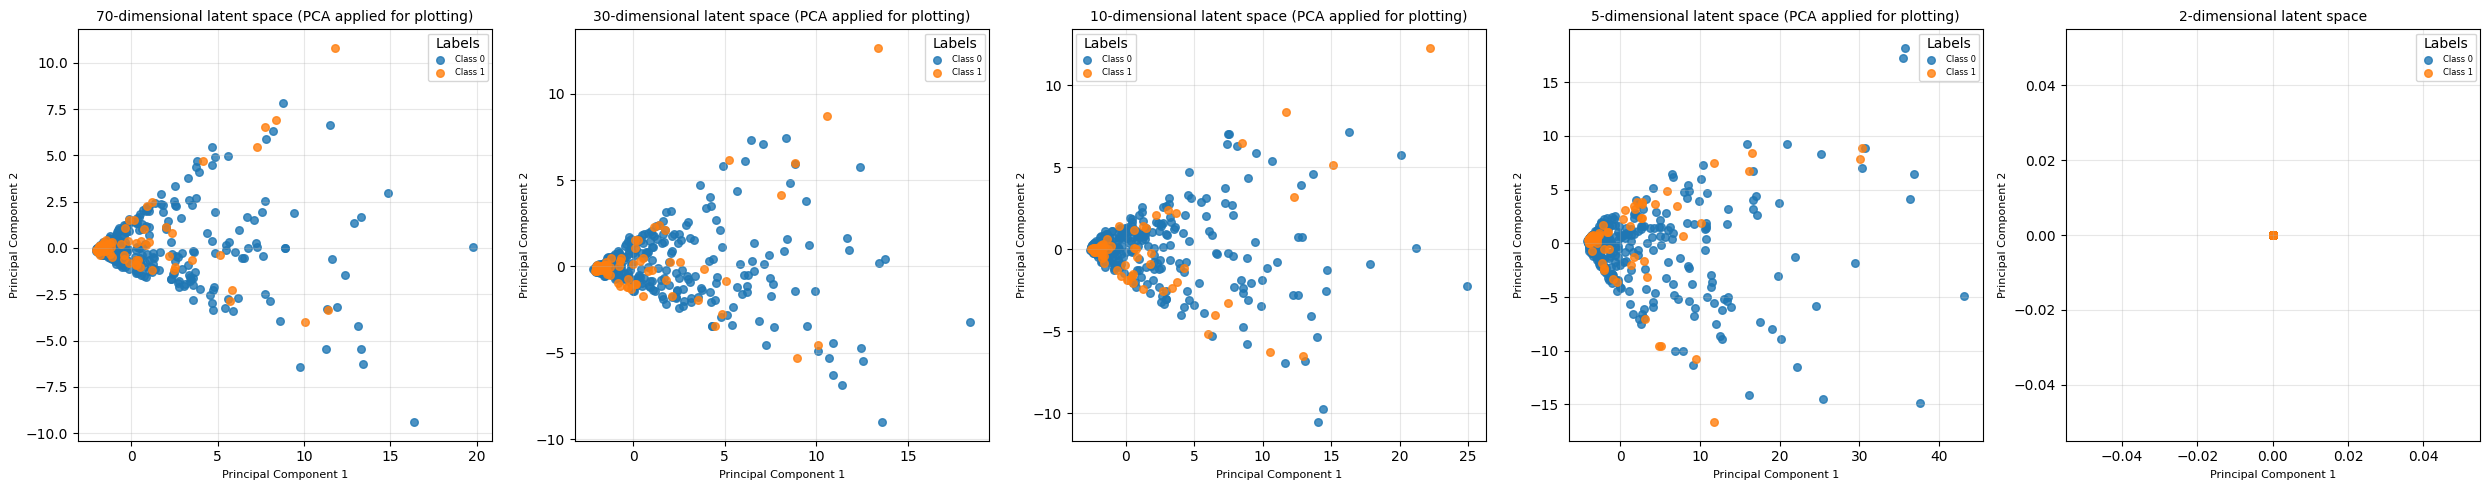

In [90]:
# try different architectures, with different dimensions 
architectures = [[300, 150, 70, 150, 300], 
                 [300, 100, 30, 100, 300], 
                 [250, 60, 10, 60, 250], 
                 [300, 100, 50, 20, 5, 20, 50, 100, 300],
                 [300, 100, 50, 10, 2, 10, 50, 100, 300]]

# Set up a figure for subplots
fig, axes = plt.subplots(1, len(architectures), figsize=(5 * len(architectures), 5))

results_mlp = []
scaler = MinMaxScaler()

for i, architecture in enumerate(architectures):  
    mlp = MLPRegressor(hidden_layer_sizes=architecture, activation='relu', max_iter=500)
    mlp.fit(X_train, X_train)
    
    # project data into latent space
    X_train_projected =  encode(X_train, mlp)
    X_test_projected = encode(X_test, mlp)

    # Normalize the data
    X_train_scaled = scaler.fit_transform(X_train_projected)
    X_test_scaled = scaler.transform(X_test_projected)

    # Train Logistic Regression
    # Automatically compute balanced class weights
    clf = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
    clf.fit(X_train_scaled, y_train)
    
    # Evaluate on training and validation sets
    clf_train_acc = accuracy_score(y_train, clf.predict(X_train_scaled))
    clf_test_acc = accuracy_score(y_test, clf.predict(X_test_scaled))

    X_train_reconstructed = decode(X_train_projected, mlp)
    X_test_reconstructed = decode(X_test_projected, mlp)

    # Calculate reconstruction loss for training data
    reconstruction_train_mse = mean_squared_error(X_train, X_train_reconstructed)
    reconstruction_test_mse = mean_squared_error(X_test, X_test_reconstructed)

    # Assuming X_train and y_train are your feature matrix and labels
    visualize_data(X_train_projected, y_train, axes[i])
    
    # Save results
    results_mlp.append({
        "Latent Space dimension": {X_test_projected.shape[1]}, 
        "Reconstruction Train MSE": reconstruction_train_mse,
        "Reconstruction Test MSE": reconstruction_test_mse,
        "Clustering Train Accuracy": clf_train_acc,
        "Clustering Test Accuracy": clf_test_acc,
    })

plt.tight_layout()
plt.show()

# Constant Prediction of most common class as Baseline
constant_pred_train = np.full_like(y_train, np.bincount(y_train).argmax())
constant_pred_test = np.full_like(y_test, np.bincount(y_train).argmax())

train_acc_constant = accuracy_score(y_train, constant_pred_train)
test_acc_constant = accuracy_score(y_test, constant_pred_test)
results_mlp.append({
    "Latent Space dimension": None, 
    "Reconstruction Train MSE": None,
    "Reconstruction Test MSE": None,
    "Clustering Train Accuracy": train_acc_constant,
    "Clustering Test Accuracy": test_acc_constant,
})

In [74]:
results_df = pd.DataFrame(results_mlp)
results_df

,Latent Space dimension,Reconstruction Train MSE,Reconstruction Test MSE,Clustering Train Accuracy,Clustering Test Accuracy
0,{70},0.009176,0.012358,0.641566,0.644578
1,{30},0.009707,0.012793,0.628012,0.542169
2,{10},0.011714,0.014440,0.500000,0.427711
3,{5},0.013524,0.015567,0.587349,0.493976
4,{2},0.029713,0.030901,0.326807,0.391566
5,None,NaN,NaN,0.849398,0.861446


### Results

The Autoencoder is able to successfully encode and decode the data, with the largest MSE = 0.03 for the reconstruction from 2 latent dimensions. 

However, the labels animal_in_image does not seem to be captured in latent space. As a next step, it would make sense, to use a Neural Manifold Learning Technique like CEBRA or MARBLE, which considers behavior labels in training.  